In [ ]:
import pandas as pd

nifty50_df = pd.read_csv('nifty50.csv')

replaced_tickers = pd.read_csv('nifty50_changes.csv')
stock_changes = pd.read_csv('nifty50_changes.csv')
stock_changes['start_date'] = pd.to_datetime(stock_changes['start_date'])
stock_changes['end_date'] = pd.to_datetime(stock_changes['end_date'])

tickers = [f"NSE:{t}-EQ" for t in set(nifty50_df['Symbol'].tolist())] + stock_changes.symbol.tolist()

In [ ]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

In [ ]:
df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()

In [ ]:
import talib as ta

df.Date = pd.to_datetime(df.Date)
# Calculate RSI per stock
df['SMA20'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=20))
df['SMA20_Perc_Distance'] = (df['Close'] - df['SMA20']) / df['SMA20'] * 100

df['Entry_Price'] = df.groupby('Stock')['Open'].shift(-1)
df['Entry_Time'] = df.groupby('Stock')['Date'].shift(-1)

# df = df[df.Date >= '2020-01-01 05:30:00']

In [ ]:
signals = (
    df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))
      .sort_values(['Date', 'SMA20_Perc_Distance']).reset_index(drop=True).dropna(subset=['Entry_Price'])
)

In [49]:
from dataclasses import asdict
from tqdm.notebook import tqdm
from lib import PositionManager, Bank

rebalance_perc = 100
max_holding_period = 5000  # days
max_num_of_avgs = 3
initial_capital = 1000000
leverage = 1
tp_perc = 8
sl_perc = 100
max_positions_num = 25
mtf_rate_daily = 0.0192 / 100  # Margin funding rate (per day)


def select_stock_for_entry(pm, signals: pd.DataFrame):
    selected_stocks = []
    for _, signal in signals.iterrows():
        if pm.get_position(signal.Stock) is None:
            if signal.Stock in stock_changes.symbol.tolist():
                stock = stock_changes[stock_changes.symbol == signal.Stock]
                if signal.Date >= stock.start_date.values[0] and signal.Date <= stock.end_date.values[0]:
                    selected_stocks.append(signal)
            else:
                selected_stocks.append(signal)
    return selected_stocks[0] if len(selected_stocks) > 0 else None


def init_new_position(k, v, pm):
    selected_stock = select_stock_for_entry(pm, signals[signals.Date == k])
    if selected_stock is None:
        return None

    return pm.new_position(selected_stock.Stock, selected_stock.Entry_Time, selected_stock.Entry_Price)    

def avg_out_active_positions(k, v, pm):
    global max_num_of_avgs
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
        .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Close', 'Entry_Time', 'Entry_Price']])
    )
    apdf['perc_change'] = (apdf.Close - apdf.last_entry_price)/apdf.last_entry_price * 100
    rebalance_stocks = apdf[apdf.perc_change <= -rebalance_perc].sort_values('perc_change')
    if len(rebalance_stocks) == 0:
        return

    for k, stock in rebalance_stocks.iterrows():
        position = pm.get_position(stock.name)
        if len(position.trades) == max_num_of_avgs:
            continue

        pm.add_trade_to_position(stock.name, stock.Entry_Time, stock.Entry_Price)
        break

def book_profit(k, v, pm):
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['High', 'Close', 'Date']])
    )
    apdf = apdf[apdf.High >= apdf.tp]
    apdf['perc_change'] = (apdf.Close - apdf.avg_entry_price)/apdf.avg_entry_price * 100

    selected_stocks = apdf.sort_values('perc_change', ascending=False)
    if len(selected_stocks) > 0:
        selected_stock = selected_stocks.iloc[0]
        pm.close_position(selected_stock.name, selected_stock.Date, selected_stock.tp)


def exit_long_running_positions(k, v, pm):
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Date', 'Close']])
    )
    apdf['holding_period'] = (k - apdf.entry_time).dt.days
    long_running_positions = apdf[apdf.holding_period >= max_holding_period]
    
    for stock, lr_position in long_running_positions.iterrows():
        pm.close_position(stock, lr_position.Date, lr_position.Close)
        
def book_loss(k, v, pm):
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Low', 'Close', 'Date']])
    )
    apdf = apdf[apdf.Low <= apdf.sl]
    apdf['perc_change'] = (apdf.avg_entry_price - apdf.Close)/apdf.avg_entry_price * 100

    selected_stocks = apdf.sort_values('perc_change', ascending=False)
    for selected_stock in selected_stocks.itertuples():
        pm.close_position(selected_stock.Index, selected_stock.Date, selected_stock.sl)
        
def exit_if_removed_from_index(k, v, pm):
    if not pm.has_active_positions():
        return

    for p in pm.get_active_positions():
        if p.stock not in stock_changes.symbol.tolist():
            continue
        stock = stock_changes[stock_changes.symbol == p.stock]
        if k > stock.end_date.values[0]:
            pm.close_position(p.stock, k, v[v.Stock == p.stock].Close.values[0])

def exit_position(k, v, pm):
    book_profit(k, v, pm)
    # book_loss(k, v, pm)
    exit_if_removed_from_index(k, v, pm)
    exit_long_running_positions(k, v, pm)

def backtest(pm):
    pb = tqdm(total=len(df.Date.unique()))
    for k, v in df.groupby('Date'):
        position = init_new_position(k, v, pm)
        if position is None:
            avg_out_active_positions(k, v, pm)

        exit_position(k, v, pm)
        pb.update(1)
    pb.close()


def main():
    bank = Bank(initial_capital, max_positions_num)
    pm = PositionManager(bank, tp_perc=tp_perc, sl_perc=sl_perc, leverage=leverage, mtf_rate_daily=mtf_rate_daily)
    backtest(pm)
    return bank, pm

bank, pm = main()

  0%|          | 0/2642 [00:00<?, ?it/s]

No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital available
No capital av

In [50]:
from dataclasses import  asdict
trades = pd.DataFrame([asdict(p) for p in pm.closed_positions]).sort_values(['entry_time']).reset_index(drop=True)#.to_csv(f'{root_path}/closed_positions.csv', index=False)

In [51]:
import pandas as pd
from datetime import datetime

# Ensure entry_time and exit_time are datetime
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])

# Total trades
total_trades = len(trades)

# Win rate
win_trades = (trades['pnl'] > 0).sum()
win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

# Total profit
total_profit = trades['pnl'].sum() - trades['tax'].sum()

# Total tax
total_tax = trades['tax'].sum()

# CAGR calculation
start = trades['entry_time'].min()
end = trades['exit_time'].max()
years = (end - start).days / 365.25
initial = initial_capital  # initial_capital from your code
final = initial + total_profit
cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

# Active positions
active_position_count = sum([len(p.trades) for p in pm.get_active_positions() if p is not None])

# Period
period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

# Max holding period
max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

# Final capital
final_capital = initial + total_profit


# Calculate drawdown
trades['cum_pnl'] = trades['pnl'].cumsum()

trades['cum_max'] = trades['cum_pnl'].cummax()
trades['drawdown'] = trades['cum_pnl'] - trades['cum_max']
max_drawdown = trades['drawdown'].min()
max_drawdown_pct = abs(max_drawdown) / trades['cum_max'].max() * 100 if trades['cum_max'].max() != 0 else 0

number_of_losses = len(trades[trades['pnl'] < 0])
number_of_wins = len(trades[trades['pnl'] > 0])
profit_factor = trades[trades['pnl'] > 0]['pnl'].sum() / abs(trades[trades['pnl'] < 0]['pnl'].sum()) if abs(trades[trades['pnl'] < 0]['pnl'].sum()) > 0 else None

# Tearsheets summary
tearsheet = pd.DataFrame({
    'Metric': [
        'Period',
        'Final capital',
        'Total Trades',
        'Winners',
        'Losers',
        'Profit factor',
        'Active Position Count',
        'Max holding period (days)',
        'Avg holding period (days)',
        'Win Rate (%)',
        'Total Profit',
        'Total Tax',
        'CAGR (%)',
        'Max Drawdown (%)'
    ],
    'Value': [
        period,
        f"{final_capital:.2f}",
        f"{total_trades:,}",
        f"{number_of_wins:,}",
        f"{number_of_losses:,}",
        f"{profit_factor:.2f}" if profit_factor else "N/A",
        f"{active_position_count:,}",
        f"{max_holding_period:,}",
        f"{avg_holding_period:,}",
        f"{win_rate:.2f}",
        f"{total_profit:,.2f}",
        f"{total_tax:.2f}" if total_tax else "N/A",
        f"{cagr:.2f}" if cagr else "N/A",
        f"{max_drawdown_pct:,.2f}"
    ]
})

tearsheet

,Metric,Value
0,Period,2015-01-30 to 2025-08-18
1,Final capital,4890260.33
2,Total Trades,484
3,Winners,476
4,Losers,8
5,Profit factor,10.95
6,Active Position Count,25
7,Max holding period (days),"3,255"
8,Avg holding period (days),168
9,Win Rate (%),98.35


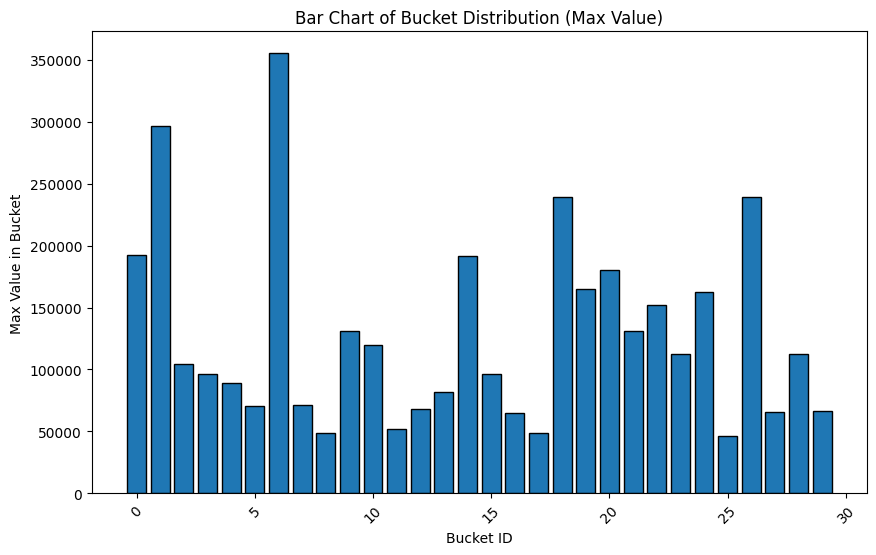

In [44]:
snapdf = pd.DataFrame(pd.DataFrame(bank.snapshot).max(), columns=['max'])
bucdf = pd.DataFrame(bank.bucket_usage_count, index=[0]).T
bucket_distribution = pd.concat([snapdf, bucdf], axis=1).rename(columns={0: 'usage_count'}).reset_index().rename(columns={'index': 'bucket_id'})

# ...existing code...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(bucket_distribution['bucket_id'])), bucket_distribution['max'], edgecolor='black')
plt.title('Bar Chart of Bucket Distribution (Max Value)')
plt.xlabel('Bucket ID')
plt.ylabel('Max Value in Bucket')
plt.xticks(rotation=45)
plt.show()

<Axes: title={'center': 'Cumulative PnL vs Exit Time'}, xlabel='exit_time'>

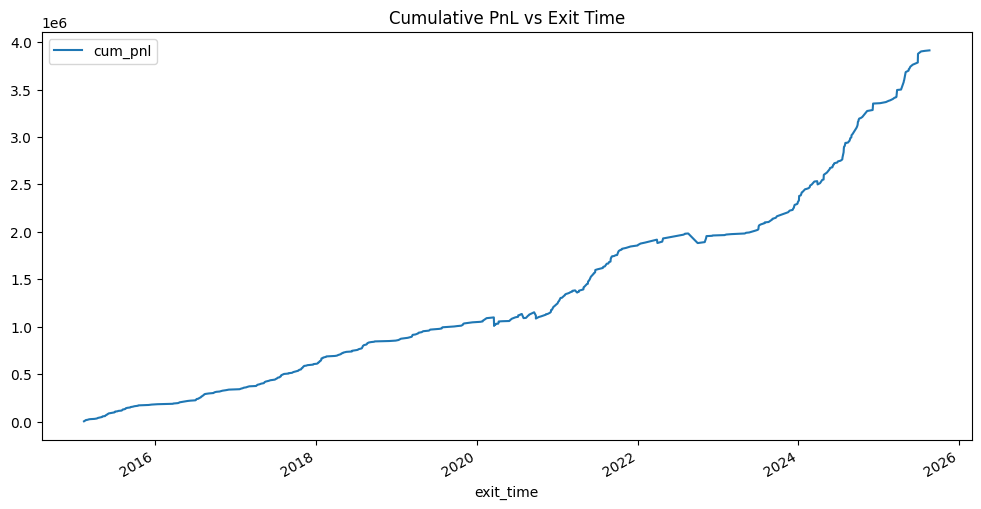

In [52]:
# ...existing code...
trades = trades.sort_values(['exit_time']).reset_index(drop=True)
trades['cum_pnl'] = trades['pnl'].cumsum()
trades.plot(x='exit_time', y='cum_pnl', title='Cumulative PnL vs Exit Time', figsize=(12, 6))

In [ ]:
# ...existing code...
import matplotlib.pyplot as plt

# Extract year from exit_time
trades['exit_year'] = trades['exit_time'].dt.year

# Group by year and sum pnl
yearly_pnl = trades.groupby('exit_year')['pnl'].sum()

plt.figure(figsize=(10, 6))
yearly_pnl.plot(kind='bar', edgecolor='black')
plt.title('Year-wise PnL')
plt.xlabel('Year')
plt.ylabel('Total PnL')
plt.xticks(rotation=45)
plt.show()
#

In [ ]:
losses = [c for c in pm.closed_positions if c.pnl < 0]
losses_df = pd.DataFrame([asdict(p) for p in losses]).sort_values(['entry_time']).reset_index(drop=True)
losses_df.to_csv('losses.csv', index=False)

In [ ]:
trades['holding_period'] = (trades['exit_time'] - trades['entry_time']).dt.days

# ...existing code...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
trades['holding_period'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Holding Periods')
plt.xlabel('Holding Period (days)')
plt.ylabel('Frequency')

In [ ]:
trades[trades.holding_period > 100]